In [23]:
# bài toán nhận diện chữ số viết tay từ ảnh đầu vào có 1 chữ số duy nhất 
# dataset : gồm từ data các bạn trong lớp thành 1 tập khoảnh 6000 ảnh 
# Mục tiêu : xây dựng mô hình có thể phân loại chính xác ảnh thành các chứ số từ 0 đến 9 

In [24]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [25]:
def preprocess_image(path, target_size=28):
    # Đọc ảnh từ đường dẫn
    img = cv2.imread(path)  
    # Nếu không đọc được ảnh (ảnh rỗng hoặc lỗi), trả về None
    if img is None:
        return None
    # Chuyển ảnh màu sang ảnh xám (grayscale)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Chuyển ảnh xám thành ảnh nhị phân (đen trắng), dùng phương pháp Otsu để chọn ngưỡng tự động
    # cv2.THRESH_BINARY_INV: nền trắng, chữ đen → đảo lại để chữ trắng, nền đen
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Tìm các đường viền (contour) của vật thể trắng trong ảnh
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Nếu không tìm thấy contour nào → ảnh rỗng → trả về None
    if not contours:
        return None
    # Lấy contour có diện tích lớn nhất (giả định là chữ số)
    cnt = max(contours, key=cv2.contourArea)
    # Lấy hình chữ nhật bao quanh contour đó (tọa độ x, y, và chiều rộng, cao)
    x, y, w, h = cv2.boundingRect(cnt)
    # Cắt vùng ảnh chứa chữ số
    digit = binary[y:y+h, x:x+w]
    # Xác định kích thước vuông tối đa giữa chiều rộng và chiều cao
    size_max = max(w, h)
    # Tạo một ảnh vuông nền đen có kích thước lớn nhất
    square = np.zeros((size_max, size_max), dtype=np.uint8)
    # Tính toán khoảng trống để căn giữa chữ số trong ảnh vuông
    x_offset = (size_max - w) // 2
    y_offset = (size_max - h) // 2
    # Chèn ảnh chữ số vào giữa ảnh vuông nền đen
    square[y_offset:y_offset+h, x_offset:x_offset+w] = digit
    # Resize ảnh vuông về kích thước 28x28 (giống input của mạng MNIST)
    resized = cv2.resize(square, (target_size, target_size), interpolation=cv2.INTER_AREA)
    # Chuẩn hóa giá trị pixel về khoảng [0, 1]
    normalized = resized.astype('float32') / 255.0
    # Thêm 1 kênh (channel) để thành dạng (28, 28, 1) – phù hợp với input của CNN
    normalized = normalized.reshape(target_size, target_size, 1)
    # Thêm batch dimension để thành dạng (1, 28, 28, 1) – dùng cho mô hình dự đoán
    normalized = np.expand_dims(normalized, axis=0)
    # Trả về ảnh đã tiền xử lý
    return normalized


In [26]:
# Hàm load dữ liệu từ thư mục chứa ảnh, với mỗi nhãn là một thư mục con (ví dụ: root/0, root/1, ...)
def load_data_from_folder(root_dir):
    x_data = []  # Danh sách lưu ảnh sau khi xử lý
    y_data = []  # Danh sách lưu nhãn tương ứng
    # Duyệt qua tất cả thư mục con trong thư mục gốc (tên thư mục là nhãn)
    for label in os.listdir(root_dir):
        label_path = os.path.join(root_dir, label)
        # Nếu không phải thư mục thì bỏ qua (phòng trường hợp file lạ trong folder gốc)
        if not os.path.isdir(label_path): 
            continue
        # Duyệt qua tất cả file trong thư mục nhãn
        for filename in os.listdir(label_path):
            # Bỏ qua những file không phải là ảnh
            if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            # Lấy đường dẫn đầy đủ đến ảnh
            file_path = os.path.join(label_path, filename)
            # Gọi hàm tiền xử lý ảnh
            processed = preprocess_image(file_path)
            # Nếu xử lý thành công thì thêm vào danh sách
            if processed is not None:
                x_data.append(processed)       # ảnh đã chuẩn hóa (1,28,28,1)
                y_data.append(int(label))     # nhãn ảnh (dạng số nguyên từ tên thư mục)
    # Chuyển danh sách thành mảng numpy, reshape lại thành (số ảnh, 28, 28, 1)
    x_data = np.array(x_data).reshape(-1, 28, 28, 1)
    # Chuyển nhãn thành mảng numpy (dạng vector 1 chiều)
    y_data = np.array(y_data)
    # Trả về tập ảnh và nhãn
    return x_data, y_data


In [27]:
root_dir = r"C:\Users\ADMIN\Desktop\ML\sort_images\sort_images"

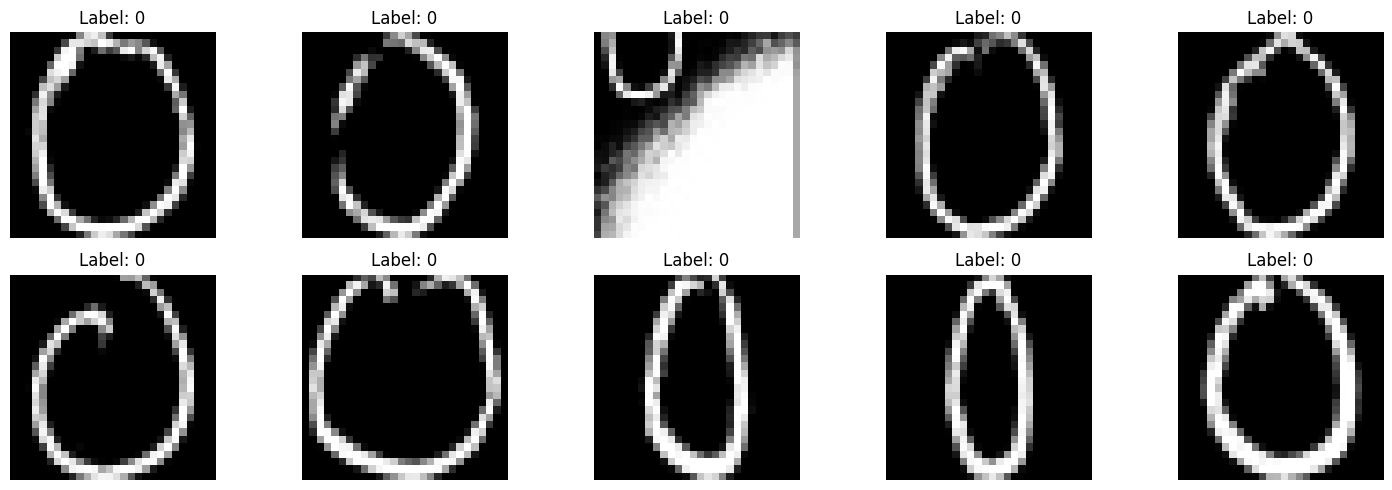

In [28]:
import matplotlib.pyplot as plt
# Giả sử bạn đã load dữ liệu bằng hàm load_data_from_folder
x_data, y_data = load_data_from_folder(root_dir)
# Tạo figure với kích thước lớn để hiển thị ảnh (chiều ngang 15 inch, chiều cao 5 inch)
plt.figure(figsize=(15, 5))
# Hiển thị 10 ảnh đầu tiên trong dữ liệu
for i in range(10):
    # Tạo subplot tại vị trí i+1 trong lưới 2 hàng x 5 cột
    plt.subplot(2, 5, i + 1)
    # Hiển thị ảnh thứ i (squeeze để loại bỏ chiều dư thừa (1,28,28,1) → (28,28))
    plt.imshow(x_data[i].squeeze(), cmap='gray')
    # Đặt tiêu đề là nhãn tương ứng
    plt.title(f"Label: {y_data[i]}")
    # Tắt hiển thị trục x/y
    plt.axis('off')
# Tự động căn chỉnh layout cho đẹp
plt.tight_layout()
# Hiển thị hình ảnh
plt.show()


In [29]:
# Lớp mạng nơ-ron tích chập (CNN)
# Input có kích thước: (batch_size, 1, 28, 28)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Lớp tích chập 1: input 1 channel (gray), output 32 channels, kernel 3x3
        self.conv1 = nn.Conv2d(1, 32, 3)
        # Lớp pooling: giảm kích thước ảnh bằng max pooling 2x2
        self.pool = nn.MaxPool2d(2, 2)
        # Lớp tích chập 2: input 32 channels, output 64 channels, kernel 3x3
        self.conv2 = nn.Conv2d(32, 64, 3)
        # Fully connected layer 1:
        # Sau 2 lần conv + pooling, ảnh (28x28) → (5x5) với 64 kênh
        # 64 * 5 * 5 = 1600 node đầu vào
        self.fc1 = nn.Linear(64 * 5 * 5, 64)
        # Fully connected layer 2: output 10 lớp tương ứng với 10 chữ số (0–9)
        self.fc2 = nn.Linear(64, 10)
    def forward(self, x):
        # Áp dụng conv1 → ReLU → pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Áp dụng conv2 → ReLU → pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten: biến tensor thành vector để đưa vào fully connected layer
        x = torch.flatten(x, 1)
        # FC1 → ReLU
        x = F.relu(self.fc1(x))
        # FC2 → đầu ra chưa chuẩn hóa (logits)
        x = self.fc2(x)
        return x

In [30]:
# Hàm huấn luyện mô hình cho 1 epoch
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Đặt mô hình ở chế độ huấn luyện (train mode)
    running_loss = 0.0  # Tổng loss trong epoch
    correct = 0         # Số lượng dự đoán đúng
    total = 0           # Tổng số mẫu
    # Duyệt qua từng batch trong dataloader
    for images, labels in train_loader:
        # Đưa dữ liệu lên GPU (nếu có)
        images, labels = images.to(device), labels.to(device)
        # Reset gradient của các tham số
        optimizer.zero_grad()
        # Truyền ảnh vào mô hình để lấy output
        outputs = model(images)
        # Tính loss giữa output và ground truth (nhãn thật)
        loss = criterion(outputs, labels)
        # Lan truyền ngược gradient
        loss.backward()
        # Cập nhật trọng số bằng optimizer
        optimizer.step()
        # Cộng dồn loss để tính trung bình sau này
        running_loss += loss.item()
        # Lấy nhãn dự đoán từ output (chọn class có xác suất cao nhất)
        _, predicted = torch.max(outputs, 1)
        # Tăng tổng số mẫu và số mẫu đúng
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    # Tính loss trung bình trên toàn bộ tập train
    avg_loss = running_loss / len(train_loader)
    # Tính accuracy (% mẫu dự đoán đúng)
    acc = 100 * correct / total
    # In loss (accuracy sẽ in ở ngoài nếu cần)
    print(f"Train loss: {avg_loss:.4f} - Accuracy: {acc:.2f}%")
    # Trả về loss và accuracy để dùng trong quá trình theo dõi huấn luyện
    return avg_loss, acc

# Hàm test đánh giá
from collections import defaultdict
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Hàm test: đánh giá mô hình trên tập kiểm thử (test_loader)
# Tham số:
# - model: mô hình đã huấn luyện
# - test_loader: DataLoader chứa dữ liệu test
# - criterion: hàm mất mát (loss function)
# - device: CPU hoặc GPU
# - verbose: nếu True thì in thêm độ chính xác từng số và hiển thị ma trận nhầm lẫn

def test(model, test_loader, criterion, device, verbose=False):
    model.eval()  # Đặt mô hình ở chế độ đánh giá (không học, tắt dropout, batchnorm)   
    correct = 0        # Tổng số dự đoán đúng
    total = 0          # Tổng số mẫu
    loss_total = 0.0   # Tổng loss
    class_correct = defaultdict(int)  # Số lượng đúng theo từng lớp
    class_total = defaultdict(int)    # Tổng số mẫu theo từng lớp
    all_preds = []     # Danh sách toàn bộ dự đoán
    all_labels = []    # Danh sách toàn bộ nhãn thật
    with torch.no_grad():  # Tắt gradient để tăng tốc và tiết kiệm bộ nhớ khi test
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # Truyền ảnh qua mô hình → lấy dự đoán đầu ra
            outputs = model(images)
            # Tính loss của batch hiện tại
            loss = criterion(outputs, labels)
            loss_total += loss.item()
            # Lấy class có xác suất cao nhất
            _, predicted = torch.max(outputs, 1)
            # Cộng tổng số mẫu và số đúng
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # Lưu kết quả để tạo confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            # Cập nhật đúng/sai theo từng nhãn
            for i in range(len(labels)):
                label = labels[i].item()
                pred = predicted[i].item()
                if label == pred:
                    class_correct[label] += 1
                class_total[label] += 1
    # Tính loss trung bình toàn bộ test set
    avg_loss = loss_total / len(test_loader)
    # Tính độ chính xác tổng thể (% đúng)
    acc = 100 * correct / total
    print(f"\nTest loss: {avg_loss:.4f} - Accuracy: {acc:.2f}%")
    # Nếu bật chế độ verbose, in chi tiết hơn
    if verbose:
        print("\n🎯 Độ chính xác theo từng chữ số:")
        for digit in range(10):
            if class_total[digit] > 0:
                acc_digit = 100 * class_correct[digit] / class_total[digit]
                print(f"   - Số {digit}: {acc_digit:.2f}% ({class_correct[digit]}/{class_total[digit]})")
            else:
                print(f"   - Số {digit}: Không có dữ liệu test")
        # Vẽ ma trận nhầm lẫn (confusion matrix)
        print("\n🧩 Ma trận nhầm lẫn:")
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues", values_format="d")
        plt.title("Confusion Matrix - Epoch Cuối")
        plt.show()
    return avg_loss, acc  # Trả về loss và accuracy

In [31]:
# Hàm dự đoán chữ số từ tất cả ảnh trong 1 thư mục và ghi kết quả ra file CSV
def predict_digits_from_folder(model, input_folder, output_csv, device='cpu'):
    model.eval()  # Đặt mô hình ở chế độ đánh giá (không cập nhật trọng số)
    results = []  # Danh sách lưu kết quả dự đoán [tên file, nhãn dự đoán]
    # Duyệt qua từng ảnh trong thư mục (sắp xếp tên file tăng dần)
    for filename in sorted(os.listdir(input_folder)):
        # Bỏ qua file không phải ảnh
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        # Đường dẫn đầy đủ tới ảnh
        file_path = os.path.join(input_folder, filename)
        # Gọi hàm tiền xử lý ảnh (resize, nhị phân, căn giữa, chuẩn hóa)
        processed = preprocess_image(file_path)
        # Nếu ảnh lỗi (trả về None) thì bỏ qua
        if processed is None:
            print(f"⚠️ Bỏ qua ảnh lỗi: {filename}")
            continue
        # Chuyển ảnh về tensor PyTorch (1, 28, 28, 1) → (1, 1, 28, 28)
        input_tensor = torch.tensor(processed, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
        # Không cần gradient khi dự đoán
        with torch.no_grad():
            # Truyền ảnh vào mô hình để lấy output (logits)
            output = model(input_tensor)
            # Lấy nhãn dự đoán (vị trí có xác suất cao nhất)
            predicted_label = torch.argmax(output, dim=1).item()
        # Thêm vào danh sách kết quả
        results.append([filename, predicted_label])
    # Chuyển kết quả thành DataFrame
    df = pd.DataFrame(results, columns=["filename", "predicted_label"])
    # Ghi ra file CSV (không ghi chỉ mục)
    df.to_csv(output_csv, index=False)
    print(f"✅ Đã ghi kết quả vào: {output_csv}")

In [32]:
# Load dữ liệu
x_data, y_data = load_data_from_folder(root_dir)
print(f"Số ảnh đã load: {len(x_data)}")
print(f"Shape x_data: {x_data.shape}")
print(f"Shape y_data: {y_data.shape}")

Số ảnh đã load: 6747
Shape x_data: (6747, 28, 28, 1)
Shape y_data: (6747,)


In [33]:
# Chia train/test
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, stratify=y_data, random_state=42
)

In [34]:
# Chuyển x_train (ảnh huấn luyện) từ numpy array sang tensor float32 và đổi chiều
# Gốc: (N, 28, 28, 1) → Sau permute: (N, 1, 28, 28) phù hợp với CNN (batch, channel, height, width)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)
# Tương tự với tập test
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
# Chuyển nhãn y_train sang tensor kiểu long (bắt buộc cho CrossEntropyLoss)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
# Tương tự với nhãn của tập test
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [35]:
# Tạo DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)


Epoch 1
Train loss: 1.9454 - Accuracy: 34.37%

Test loss: 1.6815 - Accuracy: 46.15%

Epoch 2
Train loss: 1.4903 - Accuracy: 52.08%

Test loss: 1.4198 - Accuracy: 57.48%

Epoch 3
Train loss: 1.2984 - Accuracy: 59.22%

Test loss: 1.3309 - Accuracy: 58.74%

Epoch 4
Train loss: 1.1889 - Accuracy: 62.22%

Test loss: 1.2803 - Accuracy: 62.07%

Epoch 5
Train loss: 1.1092 - Accuracy: 65.02%

Test loss: 1.2191 - Accuracy: 63.33%

Epoch 6
Train loss: 1.0348 - Accuracy: 67.89%

Test loss: 1.1963 - Accuracy: 64.89%

Epoch 7
Train loss: 0.9705 - Accuracy: 69.85%

Test loss: 1.2119 - Accuracy: 64.74%

Epoch 8
Train loss: 0.9009 - Accuracy: 71.65%

Test loss: 1.1653 - Accuracy: 66.37%

Epoch 9
Train loss: 0.8507 - Accuracy: 73.08%

Test loss: 1.1670 - Accuracy: 67.19%

Epoch 10
Train loss: 0.7986 - Accuracy: 74.37%

Test loss: 1.1719 - Accuracy: 66.44%

Epoch 11
Train loss: 0.7423 - Accuracy: 76.51%

Test loss: 1.1605 - Accuracy: 67.26%

Epoch 12
Train loss: 0.7047 - Accuracy: 77.49%

Test loss: 1.1

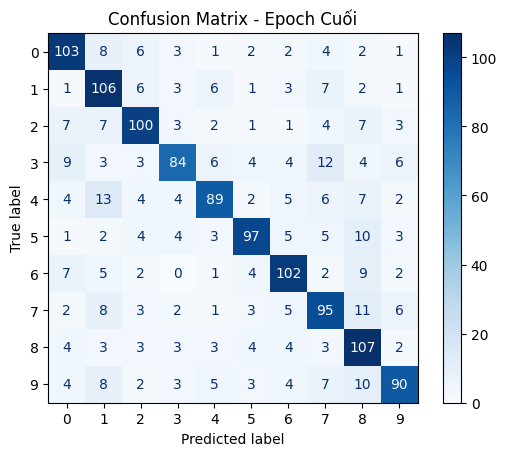

In [36]:

# Chọn thiết bị chạy: Ưu tiên GPU nếu có, không thì dùng CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Khởi tạo mô hình và đưa lên thiết bị
model = Net().to(device)
# Chọn hàm mất mát: CrossEntropyLoss phù hợp cho bài toán phân loại đa lớp
criterion = nn.CrossEntropyLoss()
# Khởi tạo optimizer Adam với learning rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Import thư viện vẽ biểu đồ
import matplotlib.pyplot as plt
# Danh sách lưu loss và accuracy để theo dõi quá trình huấn luyện
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Huấn luyện mô hình trong 20 epoch
for epoch in range(1, 51):
    print(f"\nEpoch {epoch}")
    # --- Huấn luyện trên tập train ---
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    # --- Đánh giá trên tập test ---
    is_last = (epoch == 50)  # Chỉ in chi tiết ở epoch cuối
    test_loss, test_acc = test(model, test_loader, criterion, device, verbose=is_last)
    # Ghi lại kết quả để vẽ biểu đồ sau
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)


In [37]:
# độ chính xác của tập test tăng dần theo từng epoch tuy nhiên đến một số lượng epoch nào đó độ chính xác sẽ tăng chậm (hầu như ko thay đổi) đó chính 
# độ chính xác tối đa của mô hình 



# theo ma trận nhầm lẫn ta thấy được các ô đường chéo chính của ma trận chiếm số lượng lớn nhấ trong các hàng cho thấy khả năng dự đoán của mô hình 
# tương đối tốt 
# Bên cạnh đó vẫn còn một số ô trong các hàng ngang vẫn còn giá trị cao cho thấy các số dẽ bị nhầm lẫn nhau 
# số 0 dễ bị nhầm lẫn thành số 2 (13 lần) và số 7 (9 lần)
# số 1 đẽ bị nhầm lẫn thành số 2 (15 lần) số 4 (12 lần) và số 7 (11 lần)
# số 2 dễ bị nhầm lẫn thành số 3 (8 lần)
# số 3 dễ bị nhầm lẫn thành số 4 (10 lần) số 5 (11 lần) và số 7(12 lần)
# số 4 dễ bị nhầm lẫn thành số 7 (10 lần)
# số 5 dễ bị nhầm lẫn thành số 3 (9 lần)
# số 6 dễ bị nhầm lẫn thành số 8 (7 lần)
# số 7 dễ bị nhầm lẫn thành số 2 (6 lần)
# số 8 dễ bị nhầm lẫn thành số 7 (9 lần)
# số 9 dễ bị nhầm lẫn thành số 2 (11 lần) và số 7(9 lần) 
# và theo độ chính xác ở epoch cuối cùng thì trong bài toán này các số có độ chính xác cao là : 6,7,2
# và theo độ chính xác ở epoch cuối cùng thì trong bài toán này các số có độ chính xác thấp là : 1,3

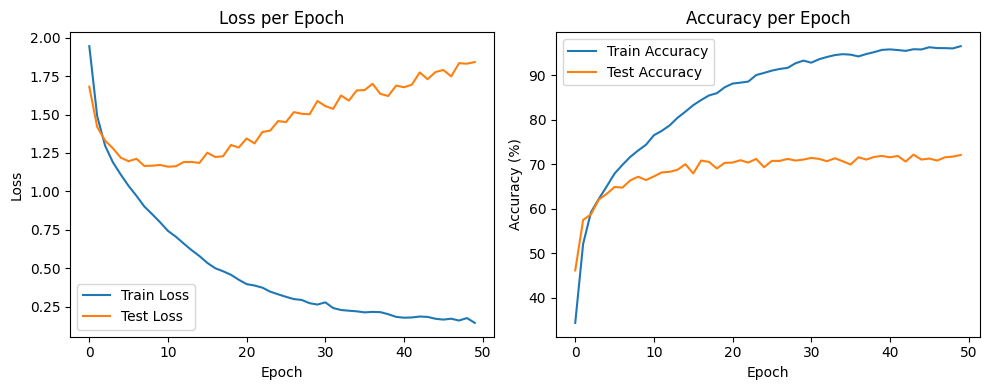

In [38]:
# Vẽ biểu đồ loss và accuracy
plt.figure(figsize=(10, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [39]:
# Dự đoán trên folder ảnh mới
INPUT_FOLDER = r"C:\Users\ADMIN\Desktop\ML\data.2025"
OUTPUT_CSV   = r"C:\Users\ADMIN\Desktop\ML\sub.csv"


predict_digits_from_folder(model, INPUT_FOLDER, OUTPUT_CSV, device=device)

⚠️ Bỏ qua ảnh lỗi: 21151445fd63ff79440449974f17109d.jpg
⚠️ Bỏ qua ảnh lỗi: 2c18ee0e7cea8354149df435532d74ae.jpeg
⚠️ Bỏ qua ảnh lỗi: 3a816aa78f56749a0822d700ff560924.jpeg
⚠️ Bỏ qua ảnh lỗi: 4abc1b5dcf1be1de6503dc072e132fa0.jpeg
⚠️ Bỏ qua ảnh lỗi: 70ebf0bec317006017a54d6c9172af45.jpeg
⚠️ Bỏ qua ảnh lỗi: 8eeee227b3f244e980b747387bc79bf2.jpeg
⚠️ Bỏ qua ảnh lỗi: 9e748b9617e26b90011f8d7c3f8a7eee.jpeg
⚠️ Bỏ qua ảnh lỗi: a008f795ae8498751f2e5feeb0b73387.jpeg
⚠️ Bỏ qua ảnh lỗi: ce2388179ec73203a60d8efedd04e0f1.jpeg
⚠️ Bỏ qua ảnh lỗi: d4b080c6ce4933f1199fad7f75e7d112.jpeg
⚠️ Bỏ qua ảnh lỗi: e21dcb1cb0571a21a013b4232d1b6a13.jpeg
⚠️ Bỏ qua ảnh lỗi: f7679411e290bfd8dc90b3eadb57460a.jpeg
⚠️ Bỏ qua ảnh lỗi: ffd4f9df7163f55474a0182265c8d810.jpeg
✅ Đã ghi kết quả vào: C:\Users\ADMIN\Desktop\ML\sub.csv
